# place cell tutorial

### Introduction

Let's say we performed an ephys recording from the hippocampus while an animal ran through a linear track. We want to identify place cells. To do this, we need to get from the raw spiking activity from all neurons to the spatial firing rate maps for spatially modulated cells. 

#insert pic here with the different steps of the analysis shown but only the start and the end visible and a question mark in between

How to we get from the raw data to place cell maps? We will walk through each step below. 

Before we get started, since we're working in python we need to import the relevant scientific libraries to help us perform our analysis. We're also going to define a few functions that we will use later on, but we don't need to go into the details of here. (Note: to execute a block of code, press the shift + enter keys at the same time)

In [7]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

In [28]:
#define variables
n_positionbins = 50 
samp_rate = 1000 #Hz

In [74]:
#define relevant functions
def smooth_with_gaussian(orig_vect,std):
    '''
    This function smooths a vector using a gaussian window with a given std
    '''
    pad_len = np.round(std*2.5)
    pad_vect = np.concatenate([np.ones(int(pad_len))*orig_vect[0], orig_vect, np.ones(int(pad_len))*orig_vect[-1]])
    gauss_window = signal.gaussian(std*7, std=std)
    vect_smooth_long = np.convolve(gauss_window,pad_vect,'same')
    vect_smooth = vect_smooth_long[int(pad_len):int(pad_len+len(orig_vect))]
    return vect_smooth

def plot_raw_data(df):
    '''
    This function plots the raw spike trains and mouse trajectories from a given dataframe
    '''
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
    fig.suptitle('Raw data')

    #plot position data
    ax1.plot(df.behavior.position[1:samp_rate])
    ax1.set_ylabel('Position (m)')
    ax1.set_xlabel('Samples')
    ax1.set_title('Mouse trajectories')

    #plot spike trains
    cmap = plt.get_cmap("tab10")
    for ineuron in range(np.shape(df.neurons)[1]):
        ax2.eventplot(np.where(df.neurons.iloc[1:samp_rate,ineuron])[0],lineoffsets = ineuron, colors = cmap(ineuron))
    ax2.set_xlabel('Samples')
    ax2.set_ylabel('Neurons')
    ax2.set_title('Spike trains');

### Section 1 - converting raw data into data by position

Let's start with the raw(-ish) data. For each neuron, we have a vector of spike counts and positions for the whole recording. The data is structured like below:

In [78]:
#insert matrix of position, spike counts, and time here
df = pd.read_pickle('toy_data.pkl') 
df.head()

behavior           neurons                                             
      time  position       0    1    2    3    4    5    6    7    8    9
0    0.000  0.095549     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1    0.001  1.020553     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2    0.002  1.364126     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3    0.003  1.674603     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4    0.004  1.676613     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

And when we plot our data, it looks something like this:

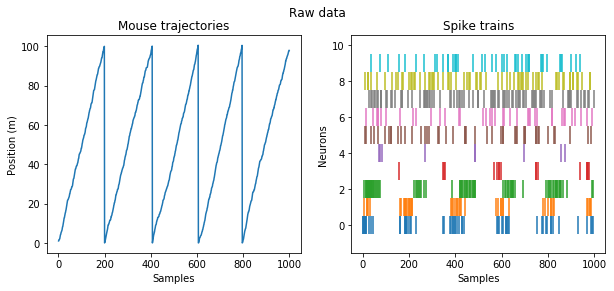

In [77]:
plot_raw_data(df)

First we want to clean our data and make sure we're only using times when the animal is running or moving above a certain speed threshold. When the animals is still, place cells from anywhere in the track are reactivated during sharp-wave ripples and this information can contaminate our place field analysis. To do this, we will replace the data when the animal is below a certain speed threshold with nan values. 

In [ ]:
speed = 
inds_when_moving = df
df_moving  = df[]

Now we want to get our data put in terms of position and make a *spike counts map*. What this means is that for each neuron, we want to know how many spikes occurred in each position in the track. To do this we will count the number of spikes in each position bin. So if the track is 100m long, we will first count the spikes in the first 1-5m from the start of the track, then  6-10m from the start, then 11-15m, etc. 

In [7]:
#insert code here to convert from raw data to position data

#print(spikecounts_map)

Now we have a *spike counts map.* But that won't be enough information to get our place cells, because we also need to know how long the animal spent in each position. If the animal spent a lot of time consuming reward at the end of the track, there will be a LOT of spikes in that location, but that could be due entirely to the time spent in that location. So we now want to get an *occupancy map* to account for time.

In [8]:
#insert code here to get occupancy map

#print(occupancy_map)

### Section 2 - generating our spatial maps
We now have a spike counts map and an occupancy map. The raw data can be a bit messy across different position bins, so to clean this up and improve our signal to noise ratio, we will smooth the maps. After smoothing the maps, we will combine them in order to get our final spatial map (spike counts normalized by occupancy) for each neuron.  

In [85]:
bin_range = 2 
spikecounts_map_smooth = smooth_with_gaussian(spikecounts_map, bin_range) #convolve with gaussian window
occupancy_map_smooth = smooth_with_gaussian(occupancy_map, bin_range)

NameError: name 'spikecounts_map' is not defined

In [10]:
spatial_map = spikecounts_map_smooth/occupancy_map_smooth

### Section 3 - identifying place cells
Now we have a spatial map for every neuron, but that doesn't mean that every neuron is spatially modulated. What we want to do next is identify place cells, neurons that *are* spatially modulated. There are many different ways to do this (spatial info, reliability, firing rate thresholds, etc.), but for the purposes of this tutorial we will use some simple criteria

In [11]:
#exclusion_criteria
#inclusion_criteria
#place_cell_maps
#make figure of place cells here 

### Section 4 - Summary

You now have identified place cells! See the full analysis process we walked through below.

#insert picture of the full analysis process here


### Section 5 - Future directions and other notes
You can use these place cells in other analyses, such as place cell reactivation and theta phase precession. You can also look at the spatial map features in more detail and quantify things such as  place fields, peak firing rates, spatial info, etc. 

For real data, you will need to account for some other things such as empty position bins with zero occupancy or spatial areas with multiple dimensions. The criteria you apply to classify place vs. non-place cells is also important because the output can change depending on which criteria you choose to apply.